In [1]:
import lightkurve as lk
from lightkurve.correctors import CBVCorrector

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.table import Table

from scipy.signal import savgol_filter as savgol

import warnings
warnings.filterwarnings("ignore")


In [2]:
# lcfile = 'tess2020324010417-s0032-0000000255559489-0200-s_lc_halo.fits'
# print('Reading TPF: %s' % lcfile)
# lc = lk.read(lcfile)
lc = lk.search_lightcurve('TIC 255559489',sector=32,radius=1000,exptime=120)[0].download().remove_nans()


In [3]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2174.229675277507,4.6494041e+05,6.3339331e+02,9.7701722e-04,681677,765.91586,15.39860,2.3003172e+05,5.1611782e+01,2.6287266e+03,8.1212435e+00,4.6494041e+05,6.3339331e+02,1000000000,nan,nan,nan,nan,765.91586,7.5294556e-05,15.39860,1.0272817e-04,-7.2344452e-02,-1.1292251e-01
2174.2310641940685,4.7076409e+05,6.3348108e+02,9.7704551e-04,681678,765.91767,15.39777,2.3009175e+05,5.1618931e+01,2.6285098e+03,8.1217842e+00,4.7076409e+05,6.3348108e+02,0,nan,nan,nan,nan,765.91767,7.5269811e-05,15.39777,1.0240110e-04,-6.9297716e-02,-9.9376969e-02
2174.233842027307,4.6799106e+05,6.3341541e+02,9.7710220e-04,681680,765.91650,15.39913,2.3002514e+05,5.1613583e+01,2.6354697e+03,8.1339521e+00,4.6799106e+05,6.3341541e+02,1000000000,nan,nan,nan,nan,765.91650,7.5291289e-05,15.39913,1.0270104e-04,-6.8386897e-02,-1.0892155e-01
2174.2366198605473,4.7043884e+05,6.3357373e+02,9.7715890e-04,681682,765.92128,15.40435,2.3010086e+05,5.1626484e+01,2.6489907e+03,8.1500721e+00,4.7043884e+05,6.3357373e+02,0,nan,nan,nan,nan,765.92128,7.5249278e-05,15.40435,1.0253952e-04,-5.2211151e-02,-8.7205984e-02
2174.238008777108,4.7134016e+05,6.3345801e+02,9.7718718e-04,681683,765.91928,15.39975,2.3009747e+05,5.1617058e+01,2.6219968e+03,8.1089592e+00,4.7134016e+05,6.3345801e+02,0,nan,nan,nan,nan,765.91928,7.5251075e-05,15.39975,1.0235333e-04,-6.1611257e-02,-9.4510354e-02
2174.2393976937856,4.7192394e+05,6.3349817e+02,9.7721559e-04,681684,765.91810,15.40005,2.3008475e+05,5.1620323e+01,2.6331270e+03,8.1316109e+00,4.7192394e+05,6.3349817e+02,0,nan,nan,nan,nan,765.91810,7.5269134e-05,15.40005,1.0255612e-04,-6.3881293e-02,-9.9439837e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200.018891012079,4.7818847e+05,6.3759241e+02,1.3153058e-03,700245,765.97353,15.47555,2.3255259e+05,5.1953945e+01,2.8410618e+03,8.4130287e+00,4.7818847e+05,6.3759241e+02,0,nan,nan,nan,nan,765.97353,7.4285825e-05,15.47555,1.0151880e-04,4.7617298e-02,1.9289482e-01


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

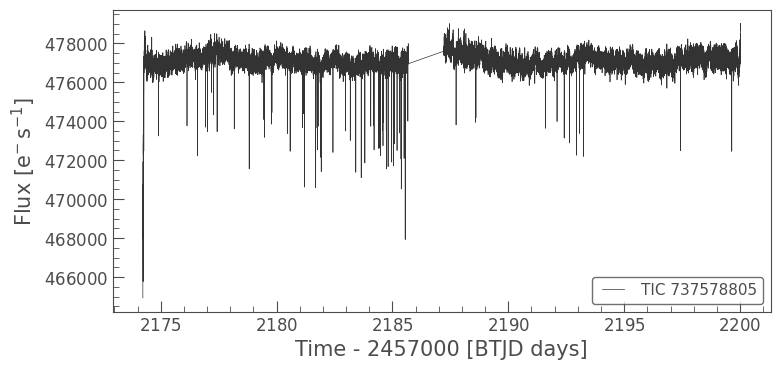

In [4]:
lc.plot()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

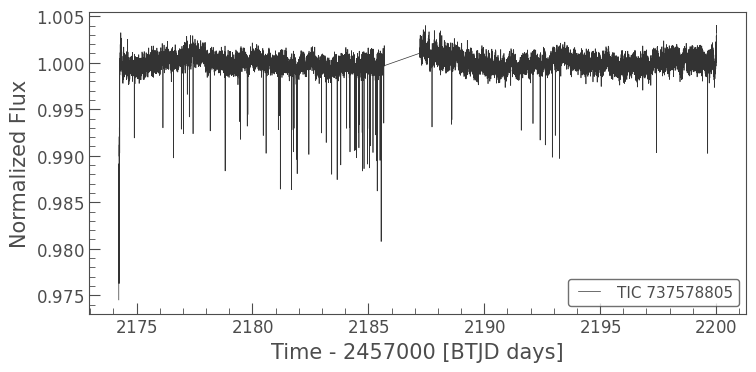

In [5]:
lc.normalize().plot()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

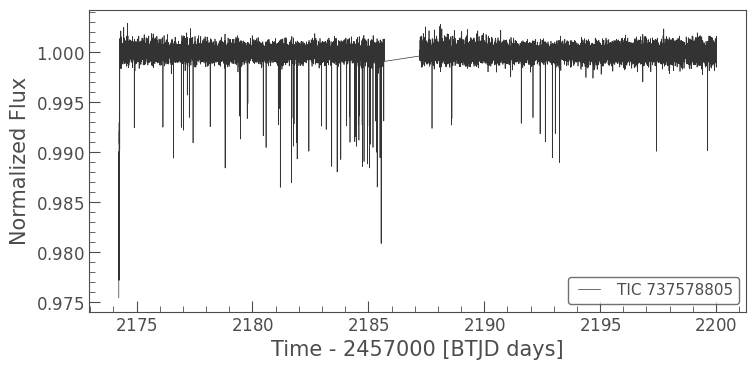

In [6]:
lc.normalize().flatten().plot()

### Now let's do a HLSP light curve

In [7]:
fname = './data/hlsp_halo_k2_llc_200007768-c4_kepler_v1_lc.fits'
halo = Table.read(fname)

In [8]:
print(halo.keys())

['time', 'flux', 'flux_err', 'centroid_col', 'centroid_row', 'quality', 'cadenceno', 'pos_corr1', 'pos_corr2', 'tr_position', 'tr_time', 'corr_flux']


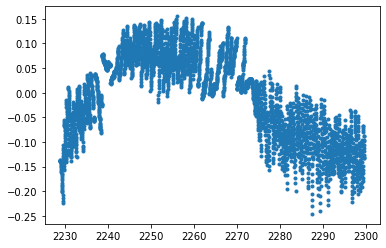

In [12]:
plt.plot(time,pos_corr2,'.')

In [44]:
m = np.isfinite(halo['corr_flux'])
halo = halo[m]
flux = halo['flux']
time = halo['time']
corr_flux = halo['corr_flux']
tr_posi = halo['tr_position']
tr_time = halo['tr_time']
pos_corr1 = halo['pos_corr1']
pos_corr2 = halo['pos_corr2']

Text(0.5, 0, 'Time (BJD)')

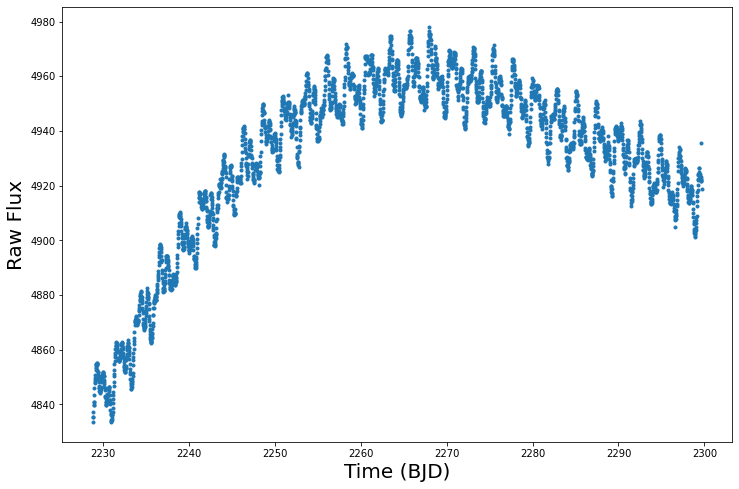

In [16]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(time,corr_flux,'.')
plt.ylabel('Raw Flux',fontsize=20)
plt.xlabel('Time (BJD)',fontsize=20)

Text(0.5, 0, 'Time (BJD)')

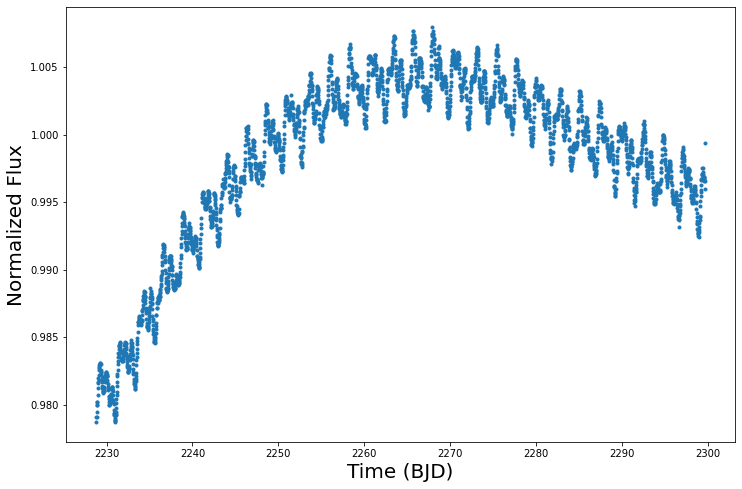

In [18]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(time,corr_flux/np.nanmedian(corr_flux),'.')
plt.ylabel('Normalized Flux',fontsize=20)
plt.xlabel('Time (BJD)',fontsize=20)

In [19]:
np.nanmedian(corr_flux)

4938.646997679816

Text(0.5, 0, 'Time (BJD)')

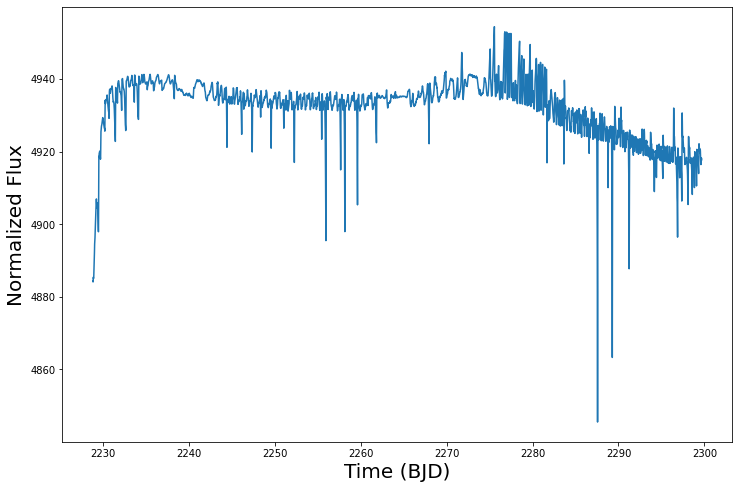

In [20]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(time,tr_posi)
plt.ylabel('Normalized Flux',fontsize=20)
plt.xlabel('Time (BJD)',fontsize=20)

Text(0.5, 0, 'Time (BJD)')

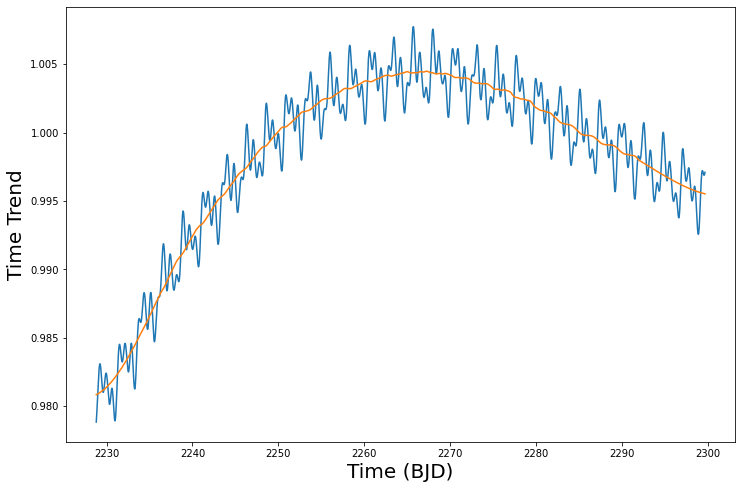

In [35]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(time,tr_time/np.nanmedian(tr_time))
# plt.plot(time,corr_flux/np.nanmedian(corr_flux)+0.01,'-')
trend = savgol(corr_flux/np.nanmedian(corr_flux),701,3)
plt.plot(time,trend)
plt.ylabel('Time Trend',fontsize=20)
plt.xlabel('Time (BJD)',fontsize=20)

Text(0.5, 0, 'Time (BJD)')

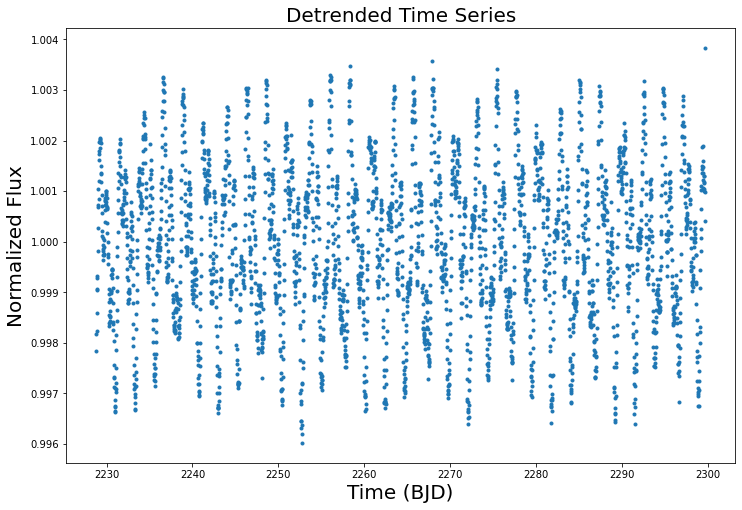

In [37]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(time,corr_flux/np.nanmedian(corr_flux)-trend+np.nanmedian(trend),'.')
plt.title('Detrended Time Series',fontsize=20)
plt.ylabel('Normalized Flux',fontsize=20)
plt.xlabel('Time (BJD)',fontsize=20)

In [38]:
from astropy.timeseries import LombScargle

In [55]:
ls = LombScargle(time,corr_flux/np.nanmedian(corr_flux)-trend+np.nanmedian(trend),normalization='psd')

In [56]:
freqs = np.linspace(0,3,10000)
power = ls.power(freqs)

Text(0, 0.5, 'PSD')

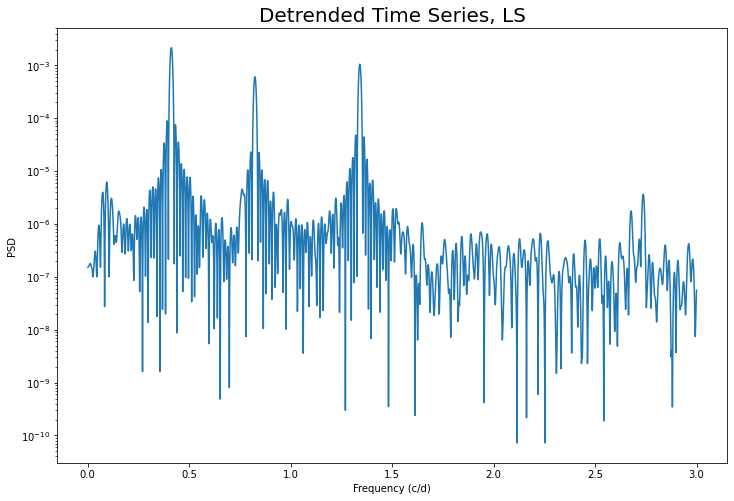

In [59]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(freqs,power)
plt.yscale('log')
plt.title('Detrended Time Series, LS',fontsize=20)
plt.xlabel('Frequency (c/d)')
plt.ylabel('PSD')

Text(0, 0.5, 'PSD')

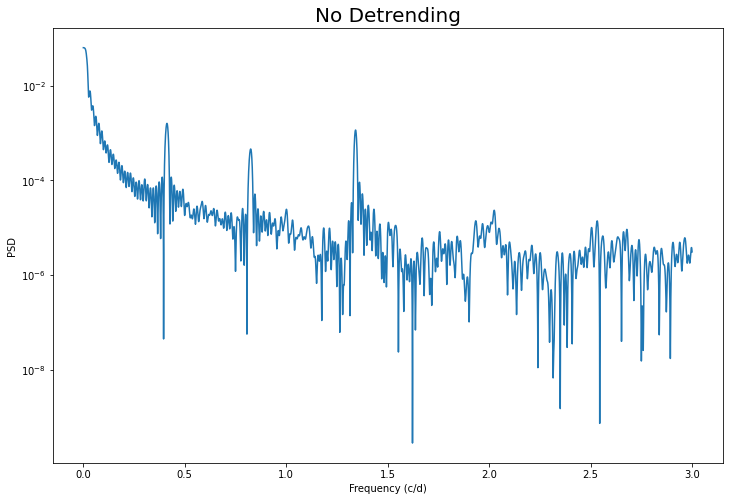

In [53]:
fig = plt.figure(figsize=(12.0,8.0))

ls = LombScargle(time,corr_flux/np.nanmedian(corr_flux),normalization='psd')
power = ls.power(freqs)
plt.plot(freqs,power)
plt.yscale('log')
plt.title('No Detrending',fontsize=20)
plt.xlabel('Frequency (c/d)')
plt.ylabel('PSD')